In [ ]:
#!pip uninstall -y catboost numpy
#!pip install numpy catboost --no-cache-dir
#!pip install scikit-learn
#!pip install pytorch-tabnet


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from IPython.display import Image, display

from scipy.stats import kurtosis, poisson, chi2_contingency, pearsonr, stats
import scipy.stats as st
import statsmodels.api as sm

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv1D, LSTM, Dense, TimeDistributed, Input,
    BatchNormalization, Bidirectional, Attention, Concatenate
)

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb


In [3]:
df1 = pd.read_csv('/content/airlines_group1.csv')

In [4]:
df1.head()

,date,airline,origin,destination,sched_dep_time,actual_dep_time,dep_delay,dep_delay_min,taxi_out,taxi_in,...,actual_duration,air_time,dist,dist_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,week
0,2020-10-15,United Airlines,"Charlotte, NC","Washington, DC",Afternoon,1444.0,-1.0,0.0,53.0,8.0,...,116.0,55.0,322.0,2,0.0,0.0,19.0,0.0,0.0,42
1,2020-10-23,United Airlines,"Pittsburgh, PA","Houston, TX",Afternoon,1611.0,-4.0,0.0,8.0,8.0,...,213.0,197.0,1117.0,5,0.0,0.0,16.0,0.0,0.0,43
2,2020-10-20,United Airlines,"Louisville, KY","Houston, TX",Morning,700.0,0.0,0.0,29.0,5.0,...,182.0,148.0,788.0,4,0.0,0.0,32.0,0.0,0.0,43
3,2020-10-20,United Airlines,"Little Rock, AR","Houston, TX",Morning,709.0,-1.0,0.0,59.0,8.0,...,129.0,62.0,374.0,2,0.0,0.0,29.0,0.0,0.0,43
4,2020-10-17,United Airlines,"Washington, DC","Sarasota/Bradenton, FL",Morning,1153.0,83.0,83.0,10.0,2.0,...,136.0,124.0,849.0,4,0.0,0.0,70.0,0.0,0.0,42


In [3]:
# Filter data for a specific airline (e.g., 'United Airlines')
df_airline = df1[df1['airline'] == 'United Airlines']

# Convert 'date' to datetime
df_airline['date'] = pd.to_datetime(df_airline['date'])

# Filter date range from 2020-10-19 to 2023-04-23
df_airline = df_airline[(df_airline['date'] >= '2020-10-19') & (df_airline['date'] <= '2023-04-23')]

# Group by date and sum arrival and departure delays
delays_by_date = df_airline.groupby('date')[['arr_delay', 'dep_delay']].sum().reset_index()

<ipython-input-3-72b75e12749e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airline['date'] = pd.to_datetime(df_airline['date'])


In [4]:
x_val = np.arange(len(delays_by_date)).reshape(-1, 1)
y_val1 = delays_by_date['arr_delay']
y_val2 = delays_by_date['dep_delay']

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Attention, Input, Conv1D, Flatten


def flatten_sequences(X):
    return X.reshape(X.shape[0], -1)

# Train-test split (80% training, 20% testing)
X_train1, X_test1, y_train1, y_test1 = train_test_split(flatten_sequences(x_val), y_val1, test_size=0.2, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(flatten_sequences(x_val), y_val2, test_size=0.2, shuffle=False)

# --- Random Forest Regressor ---
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf1.fit(X_train1, y_train1)
rf2.fit(X_train2, y_train2)
y_pred_rf1 = rf1.predict(X_test1)
y_pred_rf2 = rf2.predict(X_test2)
rmse_rf1 = np.sqrt(mean_squared_error(y_test1, y_pred_rf1))
rmse_rf2 = np.sqrt(mean_squared_error(y_test2, y_pred_rf2))

# --- Gradient Boosting Regressor ---
gb1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb1.fit(X_train1, y_train1)
gb2.fit(X_train2, y_train2)
y_pred_gb1 = gb1.predict(X_test1)
y_pred_gb2 = gb2.predict(X_test2)
rmse_gb1 = np.sqrt(mean_squared_error(y_test1, y_pred_gb1))
rmse_gb2 = np.sqrt(mean_squared_error(y_test2, y_pred_gb2))

# --- XGBoost ---
xgb1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
xgb2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
xgb1.fit(X_train1, y_train1)
xgb2.fit(X_train2, y_train2)
y_pred_xgb1 = xgb1.predict(X_test1)
y_pred_xgb2 = xgb2.predict(X_test2)
rmse_xgb1 = np.sqrt(mean_squared_error(y_test1, y_pred_xgb1))
rmse_xgb2 = np.sqrt(mean_squared_error(y_test2, y_pred_xgb2))

# --- Linear Regression ---
lin_reg1 = LinearRegression()
lin_reg2 = LinearRegression()
lin_reg1.fit(X_train1, y_train1)
lin_reg2.fit(X_train2, y_train2)
y_pred_lin1 = lin_reg1.predict(X_test1)
y_pred_lin2 = lin_reg2.predict(X_test2)
rmse_lin1 = np.sqrt(mean_squared_error(y_test1, y_pred_lin1))
rmse_lin2 = np.sqrt(mean_squared_error(y_test2, y_pred_lin2))

# --- Polynomial Regression ---
poly = PolynomialFeatures(degree=2)
X_train1_poly = poly.fit_transform(X_train1)
X_test1_poly = poly.transform(X_test1)
X_train2_poly = poly.fit_transform(X_train2)
X_test2_poly = poly.transform(X_test2)
poly_reg1 = LinearRegression()
poly_reg2 = LinearRegression()
poly_reg1.fit(X_train1_poly, y_train1)
poly_reg2.fit(X_train2_poly, y_train2)
y_pred_poly1 = poly_reg1.predict(X_test1_poly)
y_pred_poly2 = poly_reg2.predict(X_test2_poly)
rmse_poly1 = np.sqrt(mean_squared_error(y_test1, y_pred_poly1))
rmse_poly2 = np.sqrt(mean_squared_error(y_test2, y_pred_poly2))

# --- CNN-LSTM ---
def build_cnn_lstm_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train1.shape[1], 1)),
        LSTM(50, return_sequences=True),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# --- Attention-based BiLSTM ---
def build_att_bilstm_model():
    inputs = Input(shape=(X_train1.shape[1], 1))
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    att = Attention()([x, x])
    x = LSTM(50)(att)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Output RMSE values
print(f'RMSE RF1: {rmse_rf1}, RF2: {rmse_rf2}')
print(f'RMSE GB1: {rmse_gb1}, GB2: {rmse_gb2}')
print(f'RMSE XGB1: {rmse_xgb1}, XGB2: {rmse_xgb2}')
print(f'RMSE LIN1: {rmse_lin1}, LIN2: {rmse_lin2}')
print(f'RMSE POLY1: {rmse_poly1}, POLY2: {rmse_poly2}')


RMSE RF1: 58118.2921338504, RF2: 46283.070383323844
RMSE GB1: 54821.394665409396, GB2: 44260.02405531852
RMSE XGB1: 55319.02757524583, XGB2: 44869.3816686317
RMSE LIN1: 39166.94809364272, LIN2: 35059.37998547645
RMSE POLY1: 63382.6016146631, POLY2: 49775.269471382475


## CNN-LSTM Model

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense
from tensorflow.keras.layers import Input

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Preprocessing (scaling and reshaping)
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN-LSTM model (samples, time steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 1 time step, 13 features

# Split data into training and testing sets
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_reshaped, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_reshaped, y_departure, test_size=0.2, random_state=42, shuffle=False)

# Build CNN-LSTM Model
def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),  # Input layer with shape (time_steps, features)
        Conv1D(filters=64, kernel_size=1, activation='relu'),  # CNN layer with smaller kernel size
        LSTM(50),  # LSTM layer
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Initialize model for arrival delay prediction
cnn_lstm_model_arrival = build_cnn_lstm_model(X_train.shape[1:])
cnn_lstm_model_arrival.summary()

# Train the model for arrival delay
cnn_lstm_model_arrival.fit(X_train, y_train_arrival, epochs=10, batch_size=64, verbose=1)

# Evaluate the model for arrival delay
arrival_loss = cnn_lstm_model_arrival.evaluate(X_test, y_test_arrival)
print(f"Arrival delay model loss: {arrival_loss}")

# Initialize model for departure delay prediction
cnn_lstm_model_departure = build_cnn_lstm_model(X_train.shape[1:])
cnn_lstm_model_departure.summary()

# Train the model for departure delay
cnn_lstm_model_departure.fit(X_train, y_train_departure, epochs=10, batch_size=64, verbose=1)

# Evaluate the model for departure delay
departure_loss = cnn_lstm_model_departure.evaluate(X_test, y_test_departure)
print(f"Departure delay model loss: {departure_loss}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,947 (93.54 KB)

 Trainable params: 23,947 (93.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2020.5508
Epoch 2/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 676.7084
Epoch 3/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 356.8961
Epoch 4/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 286.2229
Epoch 5/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 130.9886
Epoch 6/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 83.2659
Epoch 7/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 89.1707
Epoch 8/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 77.1194
Epoch 9/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 57.7879
Epoch 10/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 67.3239
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 49.4325
Arrival delay model loss: 38.40320587158203


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,947 (93.54 KB)

 Trainable params: 23,947 (93.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2010.3552
Epoch 2/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 698.0397
Epoch 3/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 324.2190
Epoch 4/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 235.6770
Epoch 5/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 143.6949
Epoch 6/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 96.0957
Epoch 7/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 95.5771
Epoch 8/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 107.7363
Epoch 9/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 80.1678
Epoch 10/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 65.2486
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 51.8175
Departure delay model loss: 39.96125793457031


## CNN-LSTM Model Evaluation

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict arrival and departure delays
y_pred_arrival = cnn_lstm_model_arrival.predict(X_test).flatten()
y_pred_departure = cnn_lstm_model_departure.predict(X_test).flatten()

# Compute performance metrics for arrival delay
mae_arrival0 = mean_absolute_error(y_test_arrival, y_pred_arrival)
mse_arrival0 = mean_squared_error(y_test_arrival, y_pred_arrival)
rmse_arrival0 = np.sqrt(mse_arrival0)
r2_arrival0 = r2_score(y_test_arrival, y_pred_arrival)

# Compute performance metrics for departure delay
mae_departure0 = mean_absolute_error(y_test_departure, y_pred_departure)
mse_departure0 = mean_squared_error(y_test_departure, y_pred_departure)
rmse_departure0 = np.sqrt(mse_departure0)
r2_departure0 = r2_score(y_test_departure, y_pred_departure)

# Define "late" as delay > 15 minutes
threshold = 15
actual_late_arrival = (y_test_arrival > threshold).astype(int)
predicted_late_arrival = (y_pred_arrival > threshold).astype(int)

actual_late_departure = (y_test_departure > threshold).astype(int)
predicted_late_departure = (y_pred_departure > threshold).astype(int)

# Late ratio and classification metrics
def late_metrics(y_true, y_pred):
    ratio_actual = np.mean(y_true)
    ratio_predicted = np.mean(y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return ratio_actual, ratio_predicted, acc, prec, rec, f1

arrival_late_metrics = late_metrics(actual_late_arrival, predicted_late_arrival)
departure_late_metrics = late_metrics(actual_late_departure, predicted_late_departure)

# Print results in formatted output
print("\nCNN-LSTM")
print(f"Metric         | Arrival Delay       | Departure Delay")
print(f"----------------------------------------------------------")
print(f"MAE            | {mae_arrival0:.4f}       | {mae_departure0:.4f}")
print(f"MSE            | {mse_arrival0:.4f}      | {mse_departure0:.4f}")
print(f"RMSE           | {rmse_arrival0:.4f}       | {rmse_departure0:.4f}")
print(f"R² Score       | {r2_arrival0:.4f}       | {r2_departure0:.4f}")
print(f"Late Ratio (A) | {arrival_late_metrics[0]:.4f}       | {departure_late_metrics[0]:.4f}")
print(f"Late Ratio (P) | {arrival_late_metrics[1]:.4f}       | {departure_late_metrics[1]:.4f}")
print(f"Late Acc       | {arrival_late_metrics[2]:.4f}       | {departure_late_metrics[2]:.4f}")
print(f"Late Prec      | {arrival_late_metrics[3]:.4f}       | {departure_late_metrics[3]:.4f}")
print(f"Late Recall    | {arrival_late_metrics[4]:.4f}       | {departure_late_metrics[4]:.4f}")
print(f"Late F1 Score  | {arrival_late_metrics[5]:.4f}       | {departure_late_metrics[5]:.4f}")


9640/9640 ━━━━━━━━━━━━━━━━━━━━ 8s 846us/step
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 8s 845us/step

CNN-LSTM
Metric         | Arrival Delay       | Departure Delay
----------------------------------------------------------
MAE            | 0.4138       | 0.3645
MSE            | 38.4032      | 39.9613
RMSE           | 6.1970       | 6.3215
R² Score       | 0.9902       | 0.9890
Late Ratio (A) | 0.2089       | 0.1696
Late Ratio (P) | 0.2110       | 0.1721
Late Acc       | 0.9978       | 0.9975
Late Prec      | 0.9899       | 0.9857
Late Recall    | 0.9999       | 1.0000
Late F1 Score  | 0.9949       | 0.9928


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict arrival and departure delays
y_pred_arrival = cnn_lstm_model_arrival.predict(X_test).flatten()
y_pred_departure = cnn_lstm_model_departure.predict(X_test).flatten()

# Compute performance metrics for arrival delay
mae_arrival0 = mean_absolute_error(y_test_arrival, y_pred_arrival)
mse_arrival0 = mean_squared_error(y_test_arrival, y_pred_arrival)
rmse_arrival0 = np.sqrt(mse_arrival0)
r2_arrival0 = r2_score(y_test_arrival, y_pred_arrival)

# Compute performance metrics for departure delay
mae_departure0 = mean_absolute_error(y_test_departure, y_pred_departure)
mse_departure0 = mean_squared_error(y_test_departure, y_pred_departure)
rmse_departure0 = np.sqrt(mse_departure0)
r2_departure0 = r2_score(y_test_departure, y_pred_departure)

# Print results in formatted output
print()
print("CNN-LSTM")
print(f"Metric         | Arrival Delay       | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival0:.4f}       | {mae_departure0:.4f}")
print(f"MSE            | {mse_arrival0:.4f}      | {mse_departure0:.4f}")
print(f"RMSE           | {rmse_arrival0:.4f}       | {rmse_departure0:.4f}")
print(f"R² Score       | {r2_arrival0:.4f}       | {r2_departure0:.4f}")


9640/9640 ━━━━━━━━━━━━━━━━━━━━ 8s 835us/step
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 8s 875us/step

CNN-LSTM
Metric         | Arrival Delay       | Departure Delay
-------------------------------------------------
MAE            | 0.4138       | 0.3645
MSE            | 38.4032      | 39.9613
RMSE           | 6.1970       | 6.3215
R² Score       | 0.9902       | 0.9890


## CNN-LSTM Model Prediction graph

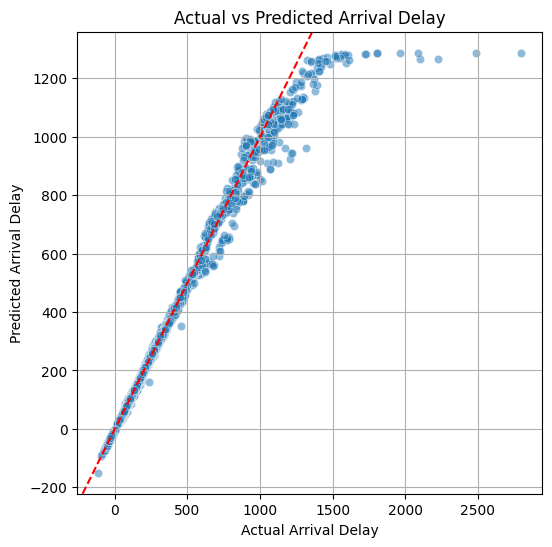

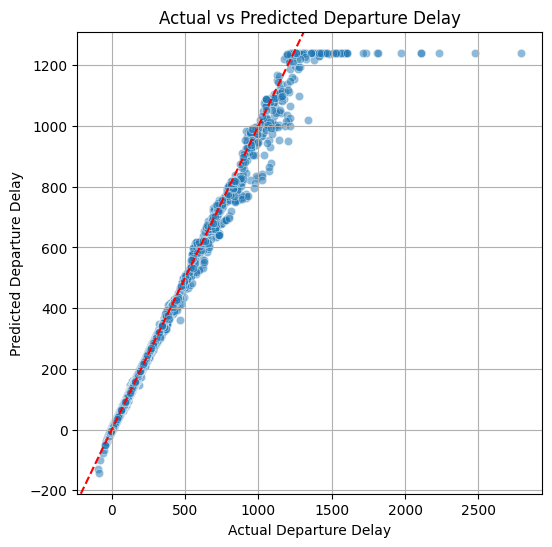

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid()
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid()
plt.show()


## ATT-BI-LSTM Model

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Attention

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Preprocessing (scaling and reshaping)
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for BiLSTM (samples, time steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 1 time step, 13 features

# Split data into training and testing sets
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_reshaped, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_reshaped, y_departure, test_size=0.2, random_state=42, shuffle=False)

# Build ATT-BI-LSTM Model
def build_att_bilstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(50, return_sequences=True))(inputs)
    attention = Attention()([x, x])  # Self-attention mechanism
    x = tf.keras.layers.GlobalAveragePooling1D()(attention)  # Global pooling after attention
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Initialize and train model for arrival delay prediction
att_bilstm_model_arrival = build_att_bilstm_model(X_train.shape[1:])
att_bilstm_model_arrival.summary()
att_bilstm_model_arrival.fit(X_train, y_train_arrival, epochs=10, batch_size=64, verbose=1)

# Evaluate the model for arrival delay
arrival_loss1 = att_bilstm_model_arrival.evaluate(X_test, y_test_arrival)
print(f"Arrival delay model loss: {arrival_loss1}")

# Initialize and train model for departure delay prediction
att_bilstm_model_departure = build_att_bilstm_model(X_train.shape[1:])
att_bilstm_model_departure.summary()
att_bilstm_model_departure.fit(X_train, y_train_departure, epochs=10, batch_size=64, verbose=1)

# Evaluate the model for departure delay
departure_loss1 = att_bilstm_model_departure.evaluate(X_test, y_test_departure)
print(f"Departure delay model loss: {departure_loss1}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1, 100)    │     25,600 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 100)    │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        101 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,701 (100.39 KB)

 Trainable params: 25,701 (100.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19279/19279 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 1717.3024
Epoch 2/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 349.4168
Epoch 3/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 125.8442
Epoch 4/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 65.1167
Epoch 5/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 55.8169
Epoch 6/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 36.2032
Epoch 7/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 39.6747
Epoch 8/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 34.9688
Epoch 9/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 35.8990
Epoch 10/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 41.3382
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 22.2064
Arrival delay model loss: 16.059438705444336


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 1, 100)    │     25,600 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 1, 100)    │          0 │ bidirectional_1[… │
│ (Attention)         │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ attention_1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        101 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,701 (100.39 KB)

 Trainable params: 25,701 (100.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 1675.5654
Epoch 2/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 305.2903
Epoch 3/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 114.1880
Epoch 4/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 77.2962
Epoch 5/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 78.7385
Epoch 6/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 42.8469
Epoch 7/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 33.0809
Epoch 8/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 24.6625
Epoch 9/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 54.2121
Epoch 10/10
19279/19279 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 46.8077
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 20.4568
Departure delay model loss: 14.666646003723145


## ATT-BI-LSTM Model Evaluation

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict arrival and departure delays
y_pred_arrival1 = att_bilstm_model_arrival.predict(X_test).flatten()
y_pred_departure1 = att_bilstm_model_departure.predict(X_test).flatten()

# Compute performance metrics for arrival delay
mae_arrival1 = mean_absolute_error(y_test_arrival, y_pred_arrival1)
mse_arrival1 = mean_squared_error(y_test_arrival, y_pred_arrival1)
rmse_arrival1 = np.sqrt(mse_arrival1)
r2_arrival1 = r2_score(y_test_arrival, y_pred_arrival1)

# Compute performance metrics for departure delay
mae_departure1 = mean_absolute_error(y_test_departure, y_pred_departure1)
mse_departure1 = mean_squared_error(y_test_departure, y_pred_departure1)
rmse_departure1 = np.sqrt(mse_departure1)
r2_departure1 = r2_score(y_test_departure, y_pred_departure1)

# Print results in a formatted table
print()
print("ATT-BI-LSTM")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE            | {mae_arrival1:.4f}       | {mae_departure1:.4f}")
print(f"MSE            | {mse_arrival1:.4f}       | {mse_departure1:.4f}")
print(f"RMSE           | {rmse_arrival1:.4f}       | {rmse_departure1:.4f}")
print(f"R² Score       | {r2_arrival1:.4f}       | {r2_departure1:.4f}")


  40/9640 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step    

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


9640/9640 ━━━━━━━━━━━━━━━━━━━━ 9s 934us/step
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 9s 949us/step

ATT-BI-LSTM
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE            | 0.5437       | 0.4295
MSE            | 16.0594       | 14.6666
RMSE           | 4.0074       | 3.8297
R² Score       | 0.9959       | 0.9960


## ATT-BI-LSTM Model Prediction Graph

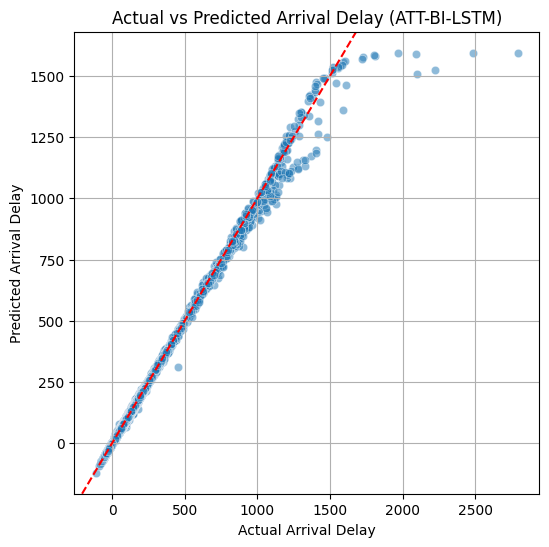

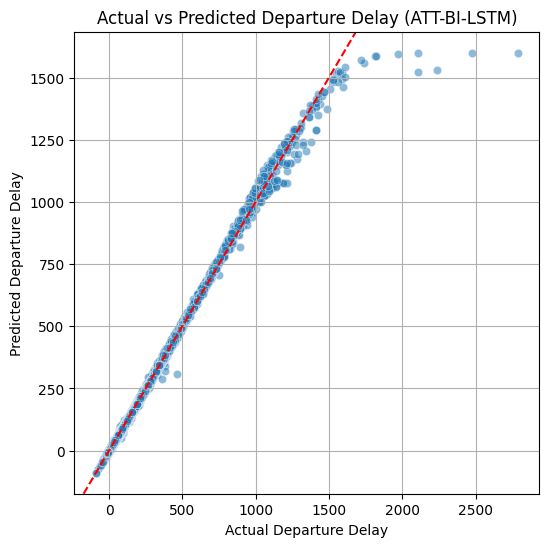

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival1, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (ATT-BI-LSTM)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid()
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure1, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (ATT-BI-LSTM)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid()
plt.show()


## Random Forest

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Extract features and target variables
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Keep as 2D array, no reshaping needed

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# Train Random Forest for Arrival Delay Prediction
rf_arrival = RandomForestRegressor(n_estimators=100, random_state=42)
rf_arrival.fit(X_train, y_train_arrival)
y_pred_arrival1 = rf_arrival.predict(X_test)

# Train Random Forest for Departure Delay Prediction
rf_departure = RandomForestRegressor(n_estimators=100, random_state=42)
rf_departure.fit(X_train, y_train_departure)
y_pred_departure1 = rf_departure.predict(X_test)

# Calculate RMSE for both models
rmse_arrival_1 = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival1))
rmse_departure_1 = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure1))

# Print RMSE values
print(f"RMSE (Random Forest) - Arrival Delay: {rmse_arrival_1:.4f}")
print(f"RMSE (Random Forest) - Departure Delay: {rmse_departure_1:.4f}")


RMSE (Random Forest) - Arrival Delay: 0.2051
RMSE (Random Forest) - Departure Delay: 0.2085


## Random Forest Evaluation

In [15]:
# Calculate Mean Absolute Error (MAE)
rf_mae_arrival = mean_absolute_error(y_test_arrival, y_pred_arrival1)
rf_mae_departure = mean_absolute_error(y_test_departure, y_pred_departure1)

# Calculate Mean Squared Error (MSE)
rf_mse_arrival = mean_squared_error(y_test_arrival, y_pred_arrival1)
rf_mse_departure = mean_squared_error(y_test_departure, y_pred_departure1)

# Calculate RMSE
rf_rmse_arrival = np.sqrt(rf_mse_arrival)
rf_rmse_departure = np.sqrt(rf_mse_departure)

# Calculate R² Score
rf_r2_arrival = r2_score(y_test_arrival, y_pred_arrival1)
rf_r2_departure = r2_score(y_test_departure, y_pred_departure1)

# Calculate Late Ratios
delay_threshold = 15
actual_late_arrival = (y_test_arrival > delay_threshold).astype(int)
predicted_late_arrival = (y_pred_arrival1 > delay_threshold).astype(int)

actual_late_departure = (y_test_departure > delay_threshold).astype(int)
predicted_late_departure = (y_pred_departure1 > delay_threshold).astype(int)

rf_late_ratio_arrival = np.mean(actual_late_arrival == predicted_late_arrival)
rf_late_ratio_departure = np.mean(actual_late_departure == predicted_late_departure)

# Print all metrics
print()
print("Random Forest")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE             | {rf_mae_arrival:.4f}       | {rf_mae_departure:.4f}")
print(f"MSE             | {rf_mse_arrival:.4f}       | {rf_mse_departure:.4f}")
print(f"RMSE            | {rf_rmse_arrival:.4f}       | {rf_rmse_departure:.4f}")
print(f"R² Score        | {rf_r2_arrival:.4f}       | {rf_r2_departure:.4f}")
print(f"Late Ratio      | {rf_late_ratio_arrival:.4f}       | {rf_late_ratio_departure:.4f}")



Random Forest
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE             | 0.0015       | 0.0015
MSE             | 0.0421       | 0.0435
RMSE            | 0.2051       | 0.2085
R² Score        | 1.0000       | 1.0000
Late Ratio      | 1.0000       | 1.0000


## Random Forest Prediction graph

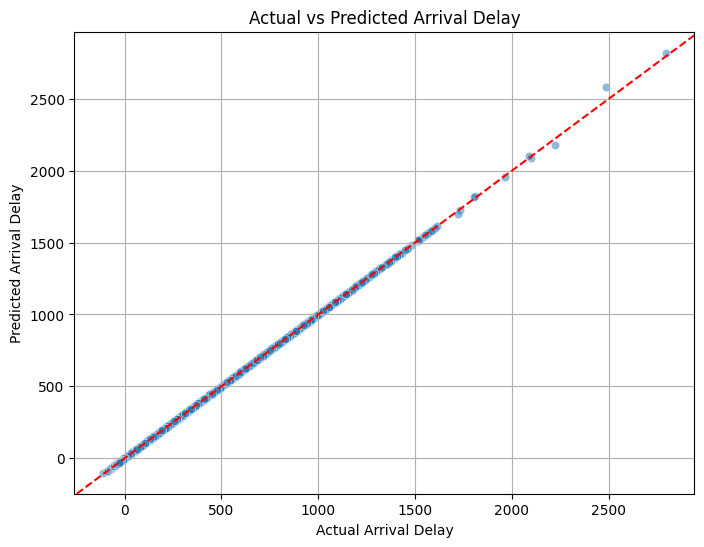

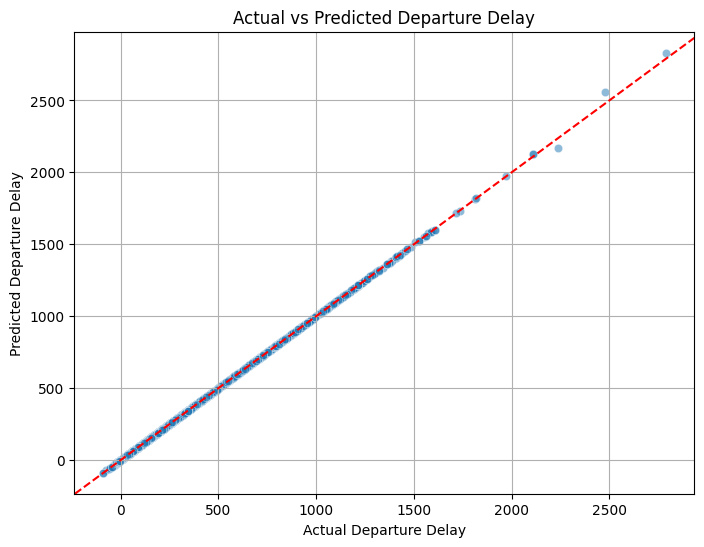

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival1, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure1, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()


##  Gradient Boosting Regressor

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # No need to reshape for GBR (tabular model)

# Split data into training and testing sets
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# --- Train Gradient Boosting Regressor for Arrival Delay ---
gbr_arrival = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbr_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_2 = gbr_arrival.predict(X_test)
rmse_arrival1 = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_2))
print(f"GBR Arrival Delay RMSE: {rmse_arrival1:.4f}")

# --- Train Gradient Boosting Regressor for Departure Delay ---
gbr_departure = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbr_departure.fit(X_train, y_train_departure)
y_pred_departure_2 = gbr_departure.predict(X_test)
rmse_departure1 = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_2))
print(f"GBR Departure Delay RMSE: {rmse_departure1:.4f}")


GBR Arrival Delay RMSE: 0.3167
GBR Departure Delay RMSE: 0.2574


##  Gradient Boosting Regressor Evaluation

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE, MSE, RMSE, and R² Score for Arrival Delay
gbr_mae_arrival = mean_absolute_error(y_test_arrival, y_pred_arrival_2)
gbr_mse_arrival = mean_squared_error(y_test_arrival, y_pred_arrival_2)
gbr_rmse_arrival = np.sqrt(gbr_mse_arrival)
gbr_r2_arrival = r2_score(y_test_arrival, y_pred_arrival_2)

# Calculate MAE, MSE, RMSE, and R² Score for Departure Delay
gbr_mae_departure = mean_absolute_error(y_test_departure, y_pred_departure_2)
gbr_mse_departure = mean_squared_error(y_test_departure, y_pred_departure_2)
gbr_rmse_departure = np.sqrt(gbr_mse_departure)
gbr_r2_departure = r2_score(y_test_departure, y_pred_departure_2)

# Calculate Late Ratios
delay_threshold = 15
gbr_actual_late_arrival = (y_test_arrival > delay_threshold).astype(int)
gbr_predicted_late_arrival = (y_pred_arrival_2 > delay_threshold).astype(int)

gbr_actual_late_departure = (y_test_departure > delay_threshold).astype(int)
gbr_predicted_late_departure = (y_pred_departure_2 > delay_threshold).astype(int)

gbr_late_ratio_arrival = np.mean(gbr_actual_late_arrival == gbr_predicted_late_arrival)
gbr_late_ratio_departure = np.mean(gbr_actual_late_departure == gbr_predicted_late_departure)

# Print performance metrics
print()
print("Gradient Boosting Regressor")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE             | {gbr_mae_arrival:.4f}       | {gbr_mae_departure:.4f}")
print(f"MSE             | {gbr_mse_arrival:.4f}       | {gbr_mse_departure:.4f}")
print(f"RMSE            | {gbr_rmse_arrival:.4f}       | {gbr_rmse_departure:.4f}")
print(f"R² Score        | {gbr_r2_arrival:.4f}       | {gbr_r2_departure:.4f}")
print(f"Late Ratio      | {gbr_late_ratio_arrival:.4f}       | {gbr_late_ratio_departure:.4f}")



Gradient Boosting Regressor
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE             | 0.0246       | 0.0204
MSE             | 0.1003       | 0.0663
RMSE            | 0.3167       | 0.2574
R² Score        | 1.0000       | 1.0000
Late Ratio      | 1.0000       | 1.0000


##  Gradient Boosting Regressor Prediction Graph

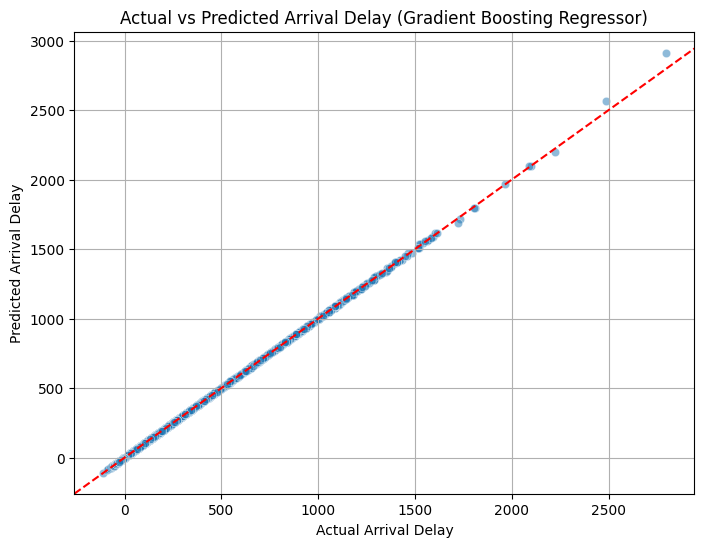

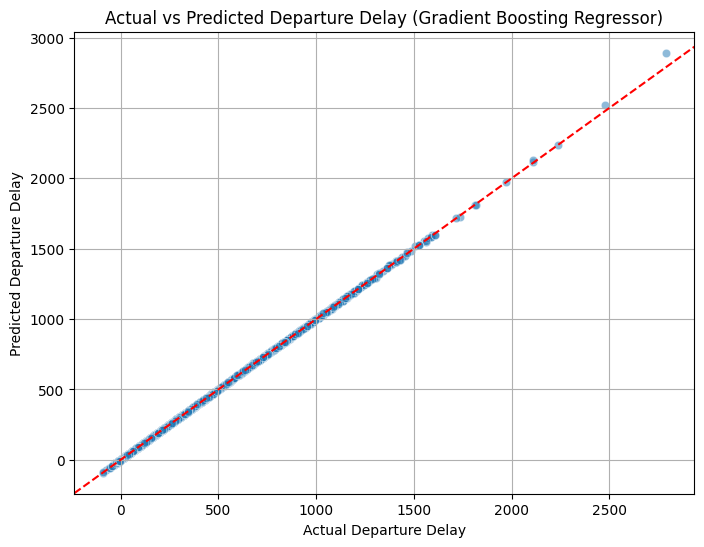

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_2, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (Gradient Boosting Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_2, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (Gradient Boosting Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()


## XGBoost Model

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select multiple features for training
X = df1_sampled[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                 'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# Train XGBoost Model for Arrival Delay Prediction
xgb_arrival = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)
xgb_arrival.fit(X_train, y_train_arrival)

# Predict and Calculate RMSE for Arrival Delay
y_pred_arrival = xgb_arrival.predict(X_test)
rmse_arrival2 = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival))
print(f"XGBoost Arrival Delay RMSE: {rmse_arrival2}")

# Train XGBoost Model for Departure Delay Prediction
xgb_departure = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)
xgb_departure.fit(X_train, y_train_departure)

# Predict and Calculate RMSE for Departure Delay
y_pred_departure = xgb_departure.predict(X_test)
rmse_departure2 = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure))
print(f"XGBoost Departure Delay RMSE: {rmse_departure2}")


XGBoost Arrival Delay RMSE: 8.813758881656812
XGBoost Departure Delay RMSE: 8.870922516223741


## XGBoost Model Evaluation

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate MAE, MSE, RMSE, and R² Score for Arrival Delay
xgb_mae_arrival = mean_absolute_error(y_test_arrival, y_pred_arrival)
xgb_mse_arrival = mean_squared_error(y_test_arrival, y_pred_arrival)
xgb_rmse_arrival = np.sqrt(xgb_mse_arrival)
xgb_r2_arrival = r2_score(y_test_arrival, y_pred_arrival)

# Calculate MAE, MSE, RMSE, and R² Score for Departure Delay
xgb_mae_departure = mean_absolute_error(y_test_departure, y_pred_departure)
xgb_mse_departure = mean_squared_error(y_test_departure, y_pred_departure)
xgb_rmse_departure = np.sqrt(xgb_mse_departure)
xgb_r2_departure = r2_score(y_test_departure, y_pred_departure)

# Calculate Late Ratios
delay_threshold = 15
xgb_actual_late_arrival = (y_test_arrival > delay_threshold).astype(int)
xgb_pred_late_arrival = (y_pred_arrival > delay_threshold).astype(int)

xgb_actual_late_departure = (y_test_departure > delay_threshold).astype(int)
xgb_pred_late_departure = (y_pred_departure > delay_threshold).astype(int)

xgb_late_ratio_arrival = np.mean(xgb_actual_late_arrival == xgb_pred_late_arrival)
xgb_late_ratio_departure = np.mean(xgb_actual_late_departure == xgb_pred_late_departure)

# Print all metrics
print()
print("XGBoost Regressor")
print(f"Metric           | Arrival Delay  | Departure Delay")
print(f"--------------------------------------------------")
print(f"MAE              | {xgb_mae_arrival:.4f}       | {xgb_mae_departure:.4f}")
print(f"MSE              | {xgb_mse_arrival:.4f}       | {xgb_mse_departure:.4f}")
print(f"RMSE             | {xgb_rmse_arrival:.4f}       | {xgb_rmse_departure:.4f}")
print(f"R² Score         | {xgb_r2_arrival:.4f}       | {xgb_r2_departure:.4f}")
print(f"Late Ratio       | {xgb_late_ratio_arrival:.4f}       | {xgb_late_ratio_departure:.4f}")



XGBoost Regressor
Metric           | Arrival Delay  | Departure Delay
--------------------------------------------------
MAE              | 0.5769       | 0.5894
MSE              | 77.6823       | 78.6933
RMSE             | 8.8138       | 8.8709
R² Score         | 0.9803       | 0.9784
Late Ratio       | 0.9961       | 0.9999


## XGBoost Model Prediction Graph

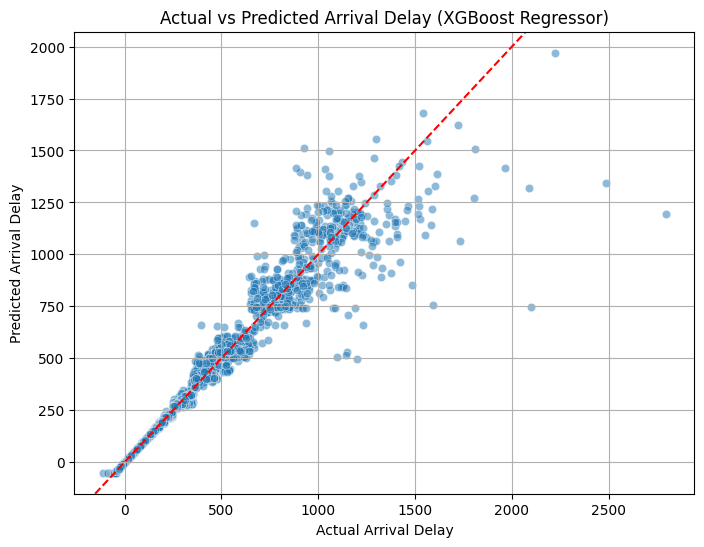

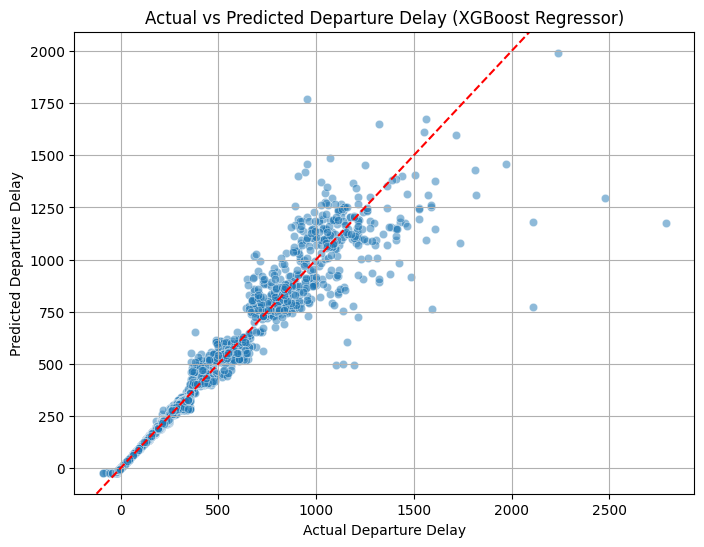

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for arrival delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (XGBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()

# Scatter plot for departure delay predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (XGBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.grid(True)
plt.show()


## LLM - Transformer Regressor

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, Add

# 1. Sample the dataset
df_sample = df1.sample(frac=0.2, random_state=42)


# 2. Select features and targets
features = df_sample[['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
                      'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay',
                      'security_delay', 'late_aircraft_delay']].values

target_arr = df_sample['arr_delay'].values
target_dep = df_sample['dep_delay'].values

# 3. Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 4. Reshape to (batch, time, features) — assume 1 time step
features_reshaped = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

# 5. Split into training and testing sets
X_train, X_test, y_train_arr, y_test_arr = train_test_split(features_reshaped, target_arr, test_size=0.2, shuffle=False)
_, _, y_train_dep, y_test_dep = train_test_split(features_reshaped, target_dep, test_size=0.2, shuffle=False)

# 6. Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x_ff, x])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# 7. Build the Transformer regression model
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# 8. Train model for arrival delay prediction
model_arr = build_transformer_model(X_train.shape[1:])
model_arr.summary()
model_arr.fit(X_train, y_train_arr, epochs=10, batch_size=64, validation_split=0.1)





Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 13)     │      7,053 │ input_layer_4[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 13)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 13)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 13)     │         26 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 128)    │      1,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 128)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 13)     │      1,677 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 13)     │          0 │ dense_5[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 13)     │         26 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1, 64)     │        896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 32)     │      2,080 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1)      │         33 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,583 (53.06 KB)

 Trainable params: 13,583 (53.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - loss: 3867.3689 - mae: 29.4766 - val_loss: 3731.8975 - val_mae: 29.4240
Epoch 2/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 3989.0618 - mae: 29.8074 - val_loss: 3731.8345 - val_mae: 29.5026
Epoch 3/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - loss: 3835.1514 - mae: 29.4784 - val_loss: 3731.6646 - val_mae: 29.2848
Epoch 4/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 3879.0933 - mae: 29.7189 - val_loss: 3731.9751 - val_mae: 29.6319
Epoch 5/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 3846.8892 - mae: 29.6879 - val_loss: 3731.6638 - val_mae: 29.3090
Epoch 6/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - loss: 3965.4214 - mae: 29.7611 - val_loss: 3731.8049 - val_mae: 29.0912
Epoch 7/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 3859.5295 - mae: 29.6557 - val_loss: 3732.6970 - val_mae: 29.8715
Epoch 8/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 3948.1357 - mae: 2

In [27]:
# 9. Evaluate on test set
pred_arr = model_arr.predict(X_test).flatten()
mae_arr = mean_absolute_error(y_test_arr, pred_arr)
rmse_arr = np.sqrt(mean_squared_error(y_test_arr, pred_arr))
r2_arr = r2_score(y_test_arr, pred_arr)

print(f"\nArrival Delay Metrics (Transformer):")
print(f"MAE: {mae_arr:.4f} | RMSE: {rmse_arr:.4f} | R²: {r2_arr:.4f}")

# 10. Repeat for departure delay
model_dep = build_transformer_model(X_train.shape[1:])
model_dep.summary()
model_dep.fit(X_train, y_train_dep, epochs=10, batch_size=64, validation_split=0.1)

pred_dep = model_dep.predict(X_test).flatten()
mae_dep = mean_absolute_error(y_test_dep, pred_dep)
rmse_dep = np.sqrt(mean_squared_error(y_test_dep, pred_dep))
r2_dep = r2_score(y_test_dep, pred_dep)

print(f"\nDeparture Delay Metrics (Transformer):")
print(f"MAE: {mae_dep:.4f} | RMSE: {rmse_dep:.4f} | R²: {r2_dep:.4f}")

9640/9640 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step

Arrival Delay Metrics (Transformer):
MAE: 29.1083 | RMSE: 61.8396 | R²: 0.0285


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 13)     │      7,053 │ input_layer_5[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 13)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 13)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 13)     │         26 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 128)    │      1,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 128)    │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1, 13)     │      1,677 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 13)     │          0 │ dense_10[0][0],   │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 13)     │         26 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1, 64)     │        896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1, 32)     │      2,080 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1, 1)      │         33 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,583 (53.06 KB)

 Trainable params: 13,583 (53.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - loss: 3554.9893 - mae: 25.6925 - val_loss: 3439.5054 - val_mae: 25.4498
Epoch 2/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - loss: 3619.1021 - mae: 25.9158 - val_loss: 3439.4890 - val_mae: 25.5730
Epoch 3/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - loss: 3679.5471 - mae: 26.0248 - val_loss: 3439.3782 - val_mae: 25.4524
Epoch 4/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - loss: 3594.9792 - mae: 25.7977 - val_loss: 3439.4683 - val_mae: 25.6248
Epoch 5/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - loss: 3711.9355 - mae: 26.0563 - val_loss: 3440.2925 - val_mae: 26.0429
Epoch 6/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 86s 4ms/step - loss: 3545.9949 - mae: 25.8102 - val_loss: 3440.2742 - val_mae: 26.0511
Epoch 7/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - loss: 3519.9075 - mae: 25.7600 - val_loss: 3439.7290 - val_mae: 25.8096
Epoch 8/10
17351/17351 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - loss: 3617.4958 - mae: 2

## LLM - Transformer Regressor Evaluation

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate Transformer model predictions
y_pred_arrival = model_arr.predict(X_test).flatten()
y_pred_departure = model_dep.predict(X_test).flatten()

# Calculate Arrival Delay Metrics
mae_arrival_4 = mean_absolute_error(y_test_arr, y_pred_arrival)
mse_arrival_4 = mean_squared_error(y_test_arr, y_pred_arrival)
rmse_arrival_4 = np.sqrt(mse_arrival_3)
r2_arrival_4 = r2_score(y_test_arr, y_pred_arrival)

# Calculate Departure Delay Metrics
mae_departure_4 = mean_absolute_error(y_test_dep, y_pred_departure)
mse_departure_4 = mean_squared_error(y_test_dep, y_pred_departure)
rmse_departure_4 = np.sqrt(mse_departure_3)
r2_departure_4 = r2_score(y_test_dep, y_pred_departure)

# Print performance metrics
print()
print("LLM- (Transformer Regressor)")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"---------------------------------------------------")
print(f"MAE             | {mae_arrival_4:.4f}       | {mae_departure_4:.4f}")
print(f"MSE             | {mse_arrival_4:.4f}       | {mse_departure_4:.4f}")
print(f"RMSE            | {rmse_arrival_4:.4f}       | {rmse_departure_4:.4f}")
print(f"R² Score        | {r2_arrival_4:.4f}       | {r2_departure_4:.4f}")


9640/9640 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
9640/9640 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step

LLM- (Transformer Regressor)
Metric          | Arrival Delay  | Departure Delay
---------------------------------------------------
MAE             | 29.1083       | 25.3274
MSE             | 3824.1383       | 3534.6439
RMSE            | 8.8138       | 8.8709
R² Score        | 0.0285       | 0.0298


## LLM - Transformer Regressor Prediction Graph

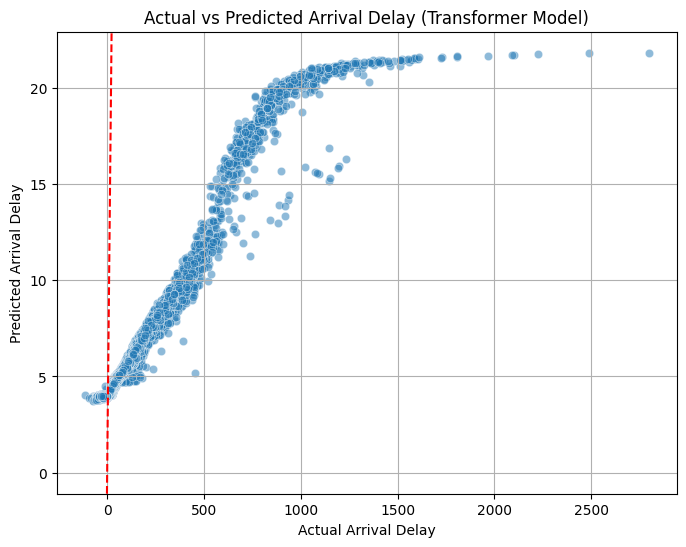

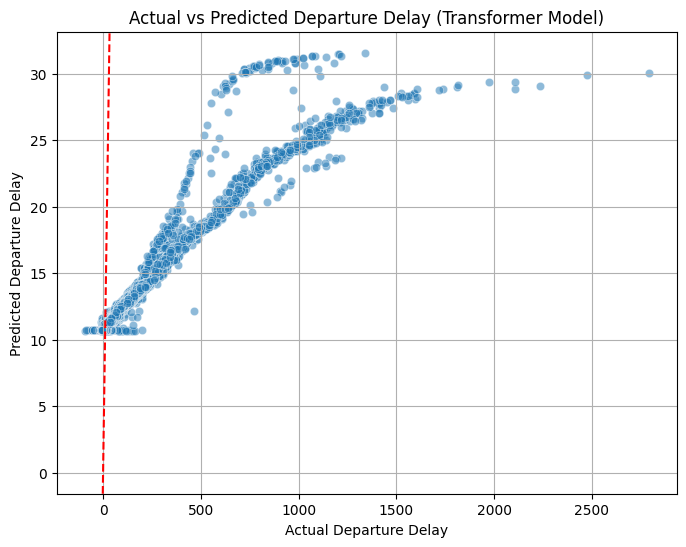

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arr, y=pred_arr, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (Transformer Model)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_dep, y=pred_dep, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (Transformer Model)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


In [33]:
#!pip uninstall -y catboost numpy
#!pip install numpy catboost --no-cache-dir



Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 52.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.


## CatBoost Regressor

In [34]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
features = ['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
            'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

X = df1_sampled[features].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling (CatBoost is actually robust without it, but keeping for consistency)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# ---- CatBoost for Arrival Delay ----
cat_arrival = CatBoostRegressor(verbose=0, random_state=42)
cat_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_cb = cat_arrival.predict(X_test)

# ---- CatBoost for Departure Delay ----
cat_departure = CatBoostRegressor(verbose=0, random_state=42)
cat_departure.fit(X_train, y_train_departure)
y_pred_departure_cb = cat_departure.predict(X_test)



## CatBoost Regressor Evaluation

In [35]:
# --- Evaluation ---
rmse_arrival_cb = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_cb))
rmse_departure_cb = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_cb))

mae_arrival_cb = mean_absolute_error(y_test_arrival, y_pred_arrival_cb)
mse_arrival_cb = mean_squared_error(y_test_arrival, y_pred_arrival_cb)
r2_arrival_cb = r2_score(y_test_arrival, y_pred_arrival_cb)

mae_departure_cb = mean_absolute_error(y_test_departure, y_pred_departure_cb)
mse_departure_cb = mean_squared_error(y_test_departure, y_pred_departure_cb)
r2_departure_cb = r2_score(y_test_departure, y_pred_departure_cb)

# --- Late Ratio Calculation ---
threshold = 15  # Delay considered late if > 15 mins

late_arrival_actual_cb = (y_test_arrival > threshold).astype(int)
late_arrival_pred_cb = (y_pred_arrival_cb > threshold).astype(int)

late_departure_actual_cb = (y_test_departure > threshold).astype(int)
late_departure_pred_cb = (y_pred_departure_cb > threshold).astype(int)

late_ratio_arrival_cb = np.mean(late_arrival_actual_cb == late_arrival_pred_cb)
late_ratio_departure_cb = np.mean(late_departure_actual_cb == late_departure_pred_cb)

# --- Print Metrics ---
print()
print("CatBoost Regressor")
print(f"Metric           | Arrival Delay  | Departure Delay")
print(f"--------------------------------------------------")
print(f"MAE              | {mae_arrival_cb:.4f}       | {mae_departure_cb:.4f}")
print(f"MSE              | {mse_arrival_cb:.4f}       | {mse_departure_cb:.4f}")
print(f"RMSE             | {rmse_arrival_cb:.4f}       | {rmse_departure_cb:.4f}")
print(f"R² Score         | {r2_arrival_cb:.4f}       | {r2_departure_cb:.4f}")
print(f"Late Ratio       | {late_ratio_arrival_cb:.4f}       | {late_ratio_departure_cb:.4f}")



CatBoost Regressor
Metric           | Arrival Delay  | Departure Delay
--------------------------------------------------
MAE              | 0.2587       | 0.2028
MSE              | 15.0366       | 18.1366
RMSE             | 3.8777       | 4.2587
R² Score         | 0.9962       | 0.9950
Late Ratio       | 1.0000       | 0.9966


## CatBoost Regressor Prediction Graph

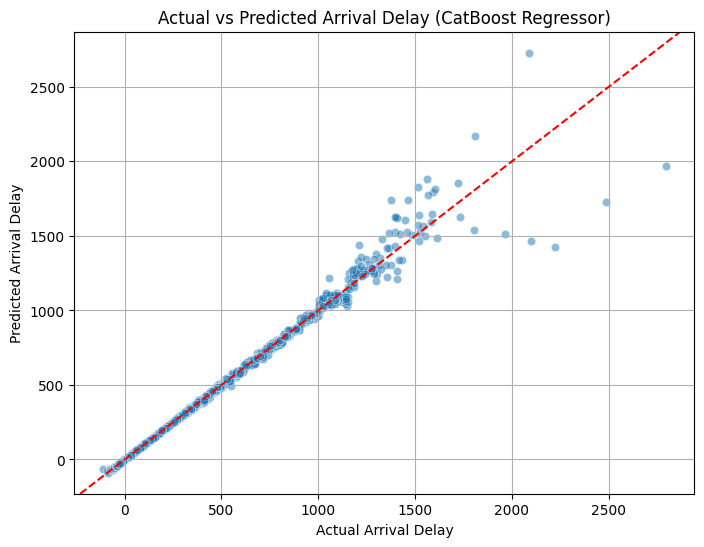

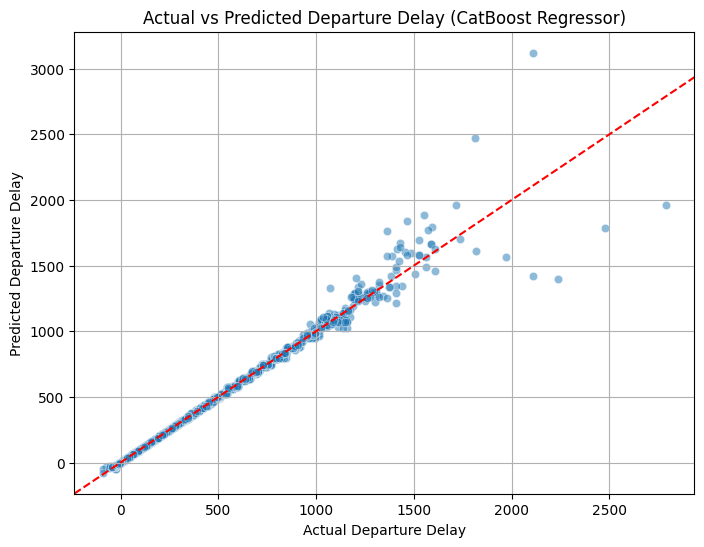

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay (CatBoost)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_cb, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (CatBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay (CatBoost)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_cb, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (CatBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


In [44]:
#!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 870.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

## TabNet Regressor

In [45]:
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

# Set a random seed for reproducibility
torch.manual_seed(42)

# --- Train TabNet Regressor for Arrival Delay ---
tabnet_arrival = TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.5, lambda_sparse=0.001)
tabnet_arrival.fit(X_train, y_train_arrival.reshape(-1, 1), max_epochs=10, batch_size=1024, virtual_batch_size=128)

# Predict using TabNet for Arrival Delay
y_pred_arrival_tabnet = tabnet_arrival.predict(X_test).flatten()

# --- Train TabNet Regressor for Departure Delay ---
tabnet_departure = TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.5, lambda_sparse=0.001)
tabnet_departure.fit(X_train, y_train_departure.reshape(-1, 1), max_epochs=10, batch_size=1024, virtual_batch_size=128)

# Predict using TabNet for Departure Delay
y_pred_departure_tabnet = tabnet_departure.predict(X_test).flatten()



/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 359.61021|  0:01:00s
epoch 1  | loss: 122.74038|  0:01:56s
epoch 2  | loss: 92.44127|  0:02:33s
epoch 3  | loss: 75.72033|  0:03:11s
epoch 4  | loss: 73.59446|  0:03:49s
epoch 5  | loss: 63.99408|  0:04:27s
epoch 6  | loss: 58.10204|  0:05:07s
epoch 7  | loss: 51.02672|  0:05:55s
epoch 8  | loss: 70.824  |  0:06:31s
epoch 9  | loss: 46.13636|  0:07:12s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 452.52271|  0:00:41s
epoch 1  | loss: 152.4522|  0:01:31s
epoch 2  | loss: 154.93138|  0:02:08s
epoch 3  | loss: 156.45342|  0:02:46s
epoch 4  | loss: 124.06936|  0:03:23s
epoch 5  | loss: 90.23909|  0:04:02s
epoch 6  | loss: 114.53006|  0:04:40s
epoch 7  | loss: 70.44908|  0:05:17s
epoch 8  | loss: 61.50304|  0:05:55s
epoch 9  | loss: 58.84453|  0:06:33s


## TabNet Regressor Evaluation

In [46]:
# Evaluation
rmse_arrival_tabnet = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_tabnet))
rmse_departure_tabnet = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_tabnet))

mae_arrival_tabnet = mean_absolute_error(y_test_arrival, y_pred_arrival_tabnet)
mse_arrival_tabnet = mean_squared_error(y_test_arrival, y_pred_arrival_tabnet)
r2_arrival_tabnet = r2_score(y_test_arrival, y_pred_arrival_tabnet)

mae_departure_tabnet = mean_absolute_error(y_test_departure, y_pred_departure_tabnet)
mse_departure_tabnet = mean_squared_error(y_test_departure, y_pred_departure_tabnet)
r2_departure_tabnet = r2_score(y_test_departure, y_pred_departure_tabnet)

# Late Ratio Calculation for TabNet
delay_threshold = 15  # in minutes

actual_late_arrival_tabnet = (y_test_arrival > delay_threshold).astype(int)
predicted_late_arrival_tabnet = (y_pred_arrival_tabnet > delay_threshold).astype(int)
tabnet_late_ratio_arrival = np.mean(actual_late_arrival_tabnet == predicted_late_arrival_tabnet)

actual_late_departure_tabnet = (y_test_departure > delay_threshold).astype(int)
predicted_late_departure_tabnet = (y_pred_departure_tabnet > delay_threshold).astype(int)
tabnet_late_ratio_departure = np.mean(actual_late_departure_tabnet == predicted_late_departure_tabnet)

# Print performance metrics
print()
print("TabNet Regressor")
print(f"Metric           | Arrival Delay  | Departure Delay")
print(f"----------------------------------------------------")
print(f"MAE              | {mae_arrival_tabnet:.4f}       | {mae_departure_tabnet:.4f}")
print(f"MSE              | {mse_arrival_tabnet:.4f}       | {mse_departure_tabnet:.4f}")
print(f"RMSE             | {rmse_arrival_tabnet:.4f}       | {rmse_departure_tabnet:.4f}")
print(f"R² Score         | {r2_arrival_tabnet:.4f}       | {r2_departure_tabnet:.4f}")
print(f"Late Ratio       | {tabnet_late_ratio_arrival:.4f}       | {tabnet_late_ratio_departure:.4f}")



TabNet Regressor
Metric           | Arrival Delay  | Departure Delay
----------------------------------------------------
MAE              | 4.6953       | 4.6160
MSE              | 196.8029       | 126.7175
RMSE             | 14.0286       | 11.2569
R² Score         | 0.9500       | 0.9652
Late Ratio       | 0.9850       | 0.9890


## TabNet Regressor Prediction Graph

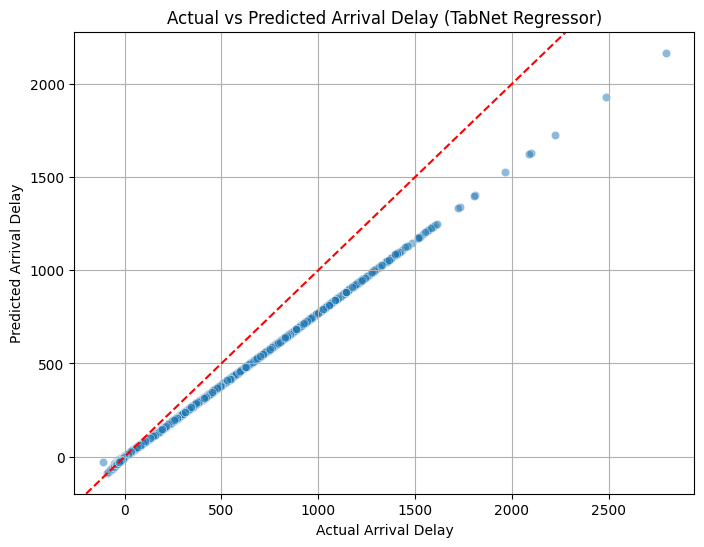

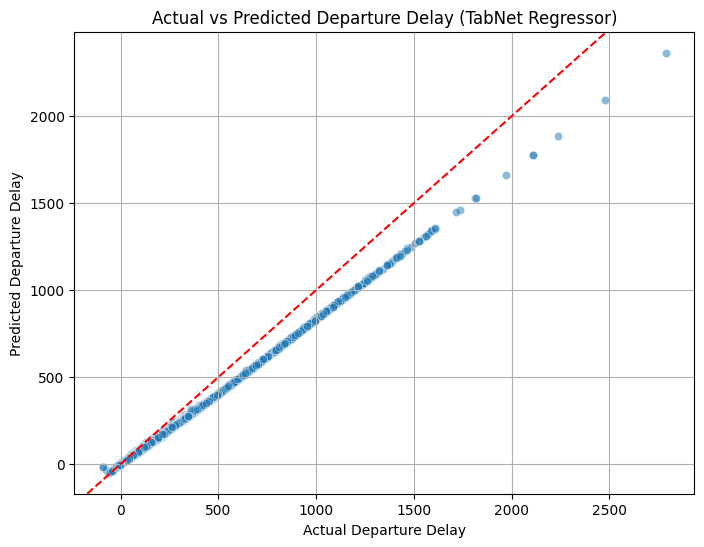

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for Arrival Delay (TabNet Regressor)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_tabnet, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (TabNet Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# Scatter plot for Departure Delay (TabNet Regressor)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_tabnet, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (TabNet Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


## KNN Regressor

In [39]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
features = ['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
            'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

X = df1_sampled[features].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions (optional step)
pca = PCA(n_components=5)  # Keep only 5 components
X_scaled_reduced = pca.fit_transform(X_scaled)

# Split data
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled_reduced, y_arrival, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_departure, y_test_departure = train_test_split(X_scaled_reduced, y_departure, test_size=0.2, random_state=42, shuffle=False)

# ---- KNN for Arrival Delay ----
knn_arrival = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)  # Parallelization
knn_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_knn = knn_arrival.predict(X_test)

# ---- KNN for Departure Delay ----
knn_departure = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)  # Parallelization
knn_departure.fit(X_train, y_train_departure)
y_pred_departure_knn = knn_departure.predict(X_test)



## KNN Regressor valuation

In [40]:
# --- Evaluation Metrics for KNN Regressor ---

# 📏 Calculate RMSE
rmse_arrival_knn = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_knn))
rmse_departure_knn = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_knn))

# 📏 Calculate MAE, MSE, R²
mae_arrival_knn = mean_absolute_error(y_test_arrival, y_pred_arrival_knn)
mse_arrival_knn = mean_squared_error(y_test_arrival, y_pred_arrival_knn)
r2_arrival_knn = r2_score(y_test_arrival, y_pred_arrival_knn)

mae_departure_knn = mean_absolute_error(y_test_departure, y_pred_departure_knn)
mse_departure_knn = mean_squared_error(y_test_departure, y_pred_departure_knn)
r2_departure_knn = r2_score(y_test_departure, y_pred_departure_knn)

# Late Ratio Calculation
delay_threshold = 15  # Minutes

# Binary classification: late = 1 if delay > 15 mins
actual_late_arrival_knn = (y_test_arrival > delay_threshold).astype(int)
predicted_late_arrival_knn = (y_pred_arrival_knn > delay_threshold).astype(int)

actual_late_departure_knn = (y_test_departure > delay_threshold).astype(int)
predicted_late_departure_knn = (y_pred_departure_knn > delay_threshold).astype(int)

# Late Ratio = accuracy of late prediction
late_ratio_arrival_knn = np.mean(actual_late_arrival_knn == predicted_late_arrival_knn)
late_ratio_departure_knn = np.mean(actual_late_departure_knn == predicted_late_departure_knn)

# 📋 Print All Metrics
print()
print("KNN Regressor")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE             | {mae_arrival_knn:.4f}       | {mae_departure_knn:.4f}")
print(f"MSE             | {mse_arrival_knn:.4f}       | {mse_departure_knn:.4f}")
print(f"RMSE            | {rmse_arrival_knn:.4f}       | {rmse_departure_knn:.4f}")
print(f"R² Score        | {r2_arrival_knn:.4f}       | {r2_departure_knn:.4f}")
print(f"Late Ratio      | {late_ratio_arrival_knn:.4f}       | {late_ratio_departure_knn:.4f}")



KNN Regressor
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE             | 3.4715       | 3.4323
MSE             | 22.3810       | 26.3975
RMSE            | 4.7309       | 5.1378
R² Score        | 0.9943       | 0.9928
Late Ratio      | 0.9909       | 0.9840


## KNN Regressor Prediction Graph

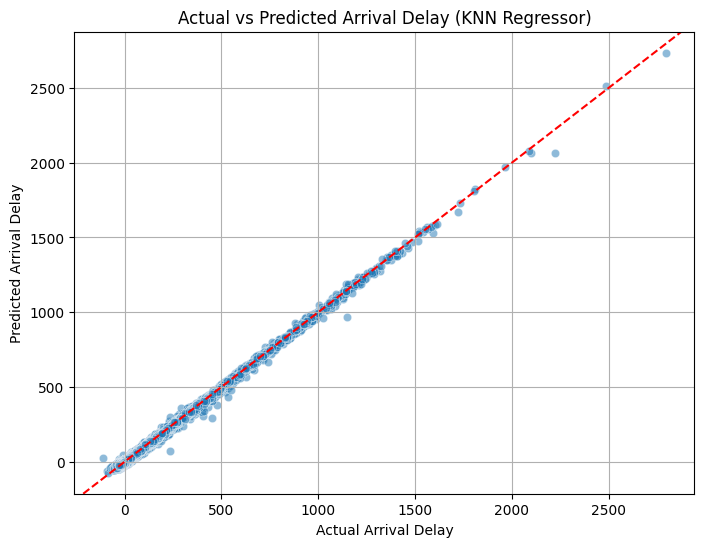

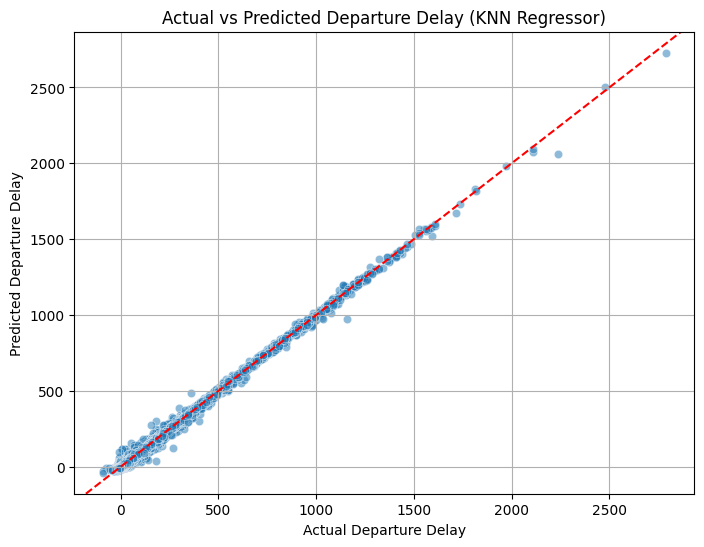

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay (KNN)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_knn, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (KNN Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay (KNN)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_knn, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (KNN Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


# AdaBoost Regressor

In [43]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
features = ['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
            'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

X = df1_sampled[features].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling (AdaBoost is sensitive to feature scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# ---- AdaBoost for Arrival Delay ----
ada_arrival = AdaBoostRegressor(n_estimators=50, random_state=42)
ada_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_ada = ada_arrival.predict(X_test)

# ---- AdaBoost for Departure Delay ----
ada_departure = AdaBoostRegressor(n_estimators=50, random_state=42)
ada_departure.fit(X_train, y_train_departure)
y_pred_departure_ada = ada_departure.predict(X_test)


# AdaBoost Regressor Evaluation

In [49]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Evaluation ---
rmse_arrival_ada = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_ada))
rmse_departure_ada = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_ada))

mae_arrival_ada = mean_absolute_error(y_test_arrival, y_pred_arrival_ada)
mse_arrival_ada = mean_squared_error(y_test_arrival, y_pred_arrival_ada)
r2_arrival_ada = r2_score(y_test_arrival, y_pred_arrival_ada)

mae_departure_ada = mean_absolute_error(y_test_departure, y_pred_departure_ada)
mse_departure_ada = mean_squared_error(y_test_departure, y_pred_departure_ada)
r2_departure_ada = r2_score(y_test_departure, y_pred_departure_ada)

# --- Late Ratio Calculation ---
delay_threshold = 15  # flights delayed more than 15 minutes are considered late

# Arrival Delay
actual_late_arrival_ada = (y_test_arrival > delay_threshold).astype(int)
predicted_late_arrival_ada = (y_pred_arrival_ada > delay_threshold).astype(int)
late_ratio_arrival_ada = np.mean(actual_late_arrival_ada == predicted_late_arrival_ada)

# Departure Delay
actual_late_departure_ada = (y_test_departure > delay_threshold).astype(int)
predicted_late_departure_ada = (y_pred_departure_ada > delay_threshold).astype(int)
late_ratio_departure_ada = np.mean(actual_late_departure_ada == predicted_late_departure_ada)

# --- Print All Metrics ---
print()
print("AdaBoost Regressor")
print(f"Metric           | Arrival Delay  | Departure Delay")
print(f"--------------------------------------------------")
print(f"MAE              | {mae_arrival_ada:.4f}       | {mae_departure_ada:.4f}")
print(f"MSE              | {mse_arrival_ada:.4f}       | {mse_departure_ada:.4f}")
print(f"RMSE             | {rmse_arrival_ada:.4f}       | {rmse_departure_ada:.4f}")
print(f"R² Score         | {r2_arrival_ada:.4f}       | {r2_departure_ada:.4f}")
print(f"Late Ratio (>%d) | {late_ratio_arrival_ada:.4f}       | {late_ratio_departure_ada:.4f}" % delay_threshold)



AdaBoost Regressor
Metric           | Arrival Delay  | Departure Delay
--------------------------------------------------
MAE              | 15.4947       | 18.0458
MSE              | 358.2151       | 379.4576
RMSE             | 18.9266       | 19.4797
R² Score         | 0.9090       | 0.8958
Late Ratio (>15) | 0.9926       | 0.9575


# AdaBoost Regressor Prediction Grapph

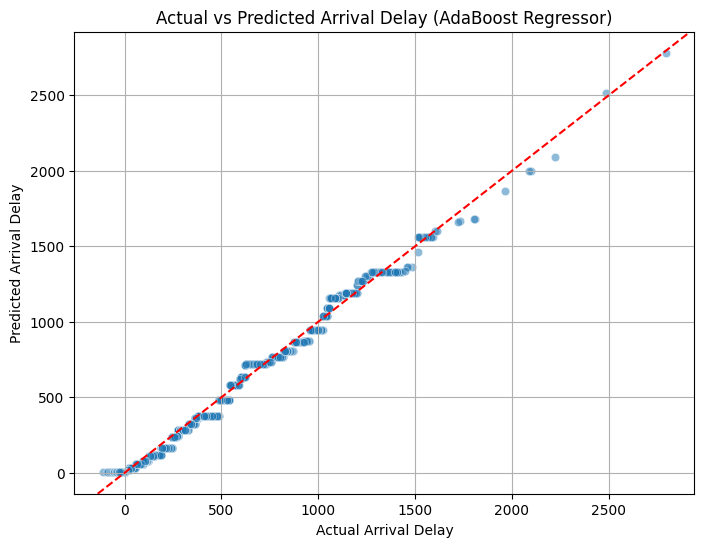

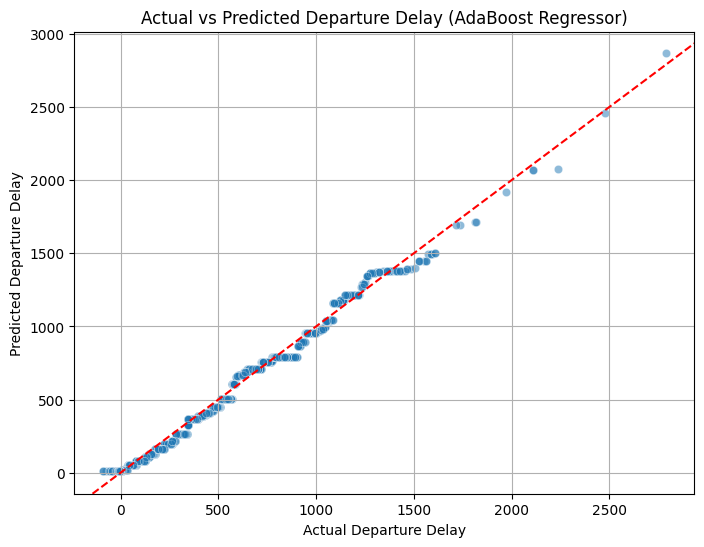

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay (AdaBoost)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_ada, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (AdaBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay (AdaBoost)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_ada, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (AdaBoost Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
features = ['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
            'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

X = df1_sampled[features].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling (LightGBM is sensitive to feature scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# ---- LightGBM for Arrival Delay ----
lgb_arrival = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_lgb = lgb_arrival.predict(X_test)

# ---- LightGBM for Departure Delay ----
lgb_departure = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_departure.fit(X_train, y_train_departure)
y_pred_departure_lgb = lgb_departure.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 1233837, number of used features: 13
[LightGBM] [Info] Start training from score 4.543964


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 1233837, number of used features: 13
[LightGBM] [Info] Start training from score 11.238305


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
import numpy as np

# --- Evaluation ---
rmse_arrival_lgb = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_lgb))
rmse_departure_lgb = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_lgb))

mae_arrival_lgb = mean_absolute_error(y_test_arrival, y_pred_arrival_lgb)
mse_arrival_lgb = mean_squared_error(y_test_arrival, y_pred_arrival_lgb)
r2_arrival_lgb = r2_score(y_test_arrival, y_pred_arrival_lgb)

mae_departure_lgb = mean_absolute_error(y_test_departure, y_pred_departure_lgb)
mse_departure_lgb = mean_squared_error(y_test_departure, y_pred_departure_lgb)
r2_departure_lgb = r2_score(y_test_departure, y_pred_departure_lgb)

# --- Late Ratio Calculation (using 15-minute threshold) ---
late_threshold = 15  # 15 minutes for late flight

# Calculate the proportion of late arrivals and departures based on the threshold
late_ratio_arrival_lgb = np.sum(y_pred_arrival_lgb > late_threshold) / len(y_pred_arrival_lgb)
late_ratio_departure_lgb = np.sum(y_pred_departure_lgb > late_threshold) / len(y_pred_departure_lgb)

# --- Print Metrics ---
print()
print("LightGBM Regressor")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE             | {mae_arrival_lgb:.4f}       | {mae_departure_lgb:.4f}")
print(f"MSE             | {mse_arrival_lgb:.4f}       | {mse_departure_lgb:.4f}")
print(f"RMSE            | {rmse_arrival_lgb:.4f}       | {rmse_departure_lgb:.4f}")
print(f"R² Score        | {r2_arrival_lgb:.4f}       | {r2_departure_lgb:.4f}")
print(f"Late Ratio      | {late_ratio_arrival_lgb:.4f}       | {late_ratio_departure_lgb:.4f}")



LightGBM Regressor
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE             | 0.1138       | 0.1086
MSE             | 11.1645       | 11.4422
RMSE            | 3.3413       | 3.3826
R² Score        | 0.9972       | 0.9969
Late Ratio      | 0.2089       | 0.1731


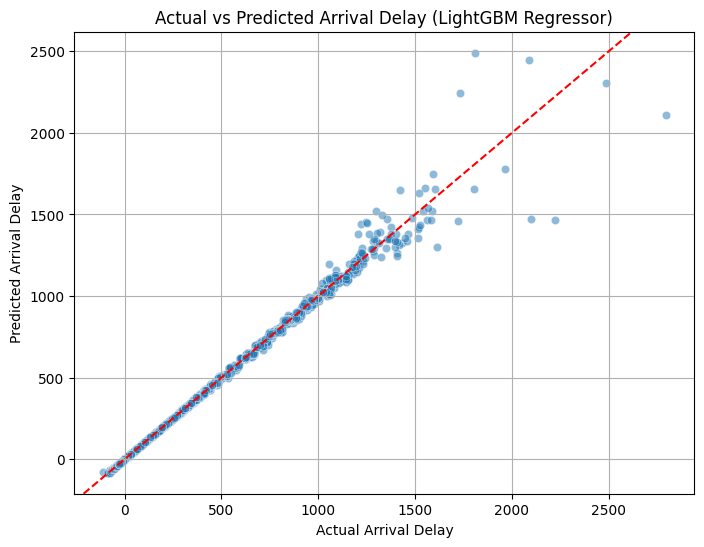

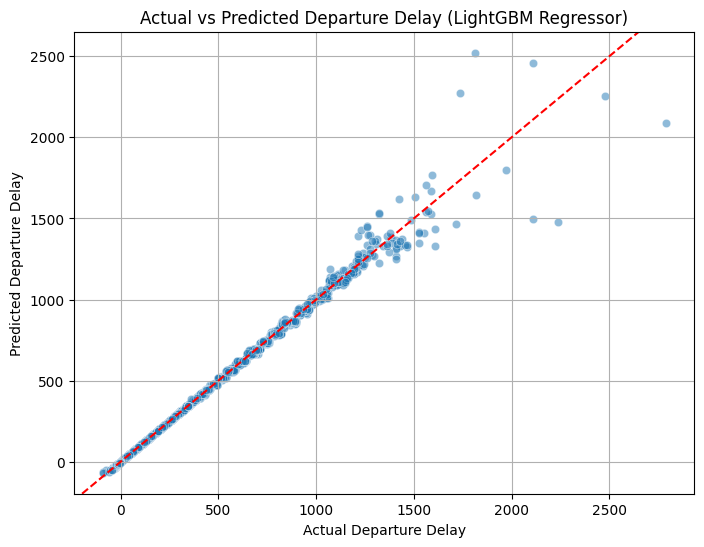

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay (LightGBM)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_lgb, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (LightGBM Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay (LightGBM)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_lgb, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (LightGBM Regressor)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
features = ['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
            'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

X = df1_sampled[features].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Feature scaling (Ridge is sensitive to feature scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# ---- Ridge for Arrival Delay ----
ridge_arrival = Ridge(alpha=1.0)
ridge_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_ridge = ridge_arrival.predict(X_test)

# ---- Ridge for Departure Delay ----
ridge_departure = Ridge(alpha=1.0)
ridge_departure.fit(X_train, y_train_departure)
y_pred_departure_ridge = ridge_departure.predict(X_test)


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Evaluation ---
rmse_arrival_ridge = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_ridge))
rmse_departure_ridge = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_ridge))

mae_arrival_ridge = mean_absolute_error(y_test_arrival, y_pred_arrival_ridge)
mse_arrival_ridge = mean_squared_error(y_test_arrival, y_pred_arrival_ridge)
r2_arrival_ridge = r2_score(y_test_arrival, y_pred_arrival_ridge)

mae_departure_ridge = mean_absolute_error(y_test_departure, y_pred_departure_ridge)
mse_departure_ridge = mean_squared_error(y_test_departure, y_pred_departure_ridge)
r2_departure_ridge = r2_score(y_test_departure, y_pred_departure_ridge)

# --- Late Ratio Calculation (using 15-minute threshold) ---
late_threshold = 15  # 15 minutes for late flight

# Calculate the proportion of late arrivals and departures based on the threshold
late_ratio_arrival_ridge = np.sum(y_pred_arrival_ridge > late_threshold) / len(y_pred_arrival_ridge)
late_ratio_departure_ridge = np.sum(y_pred_departure_ridge > late_threshold) / len(y_pred_departure_ridge)

# --- Print Metrics ---
print()
print("Ridge Regression")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE             | {mae_arrival_ridge:.4f}       | {mae_departure_ridge:.4f}")
print(f"MSE             | {mse_arrival_ridge:.4f}       | {mse_departure_ridge:.4f}")
print(f"RMSE            | {rmse_arrival_ridge:.4f}       | {rmse_departure_ridge:.4f}")
print(f"R² Score        | {r2_arrival_ridge:.4f}       | {r2_departure_ridge:.4f}")
print(f"Late Ratio      | {late_ratio_arrival_ridge:.4f}       | {late_ratio_departure_ridge:.4f}")



Ridge Regression
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE             | 0.0003       | 0.0003
MSE             | 0.0000       | 0.0000
RMSE            | 0.0004       | 0.0004
R² Score        | 1.0000       | 1.0000
Late Ratio      | 0.2094       | 0.1710


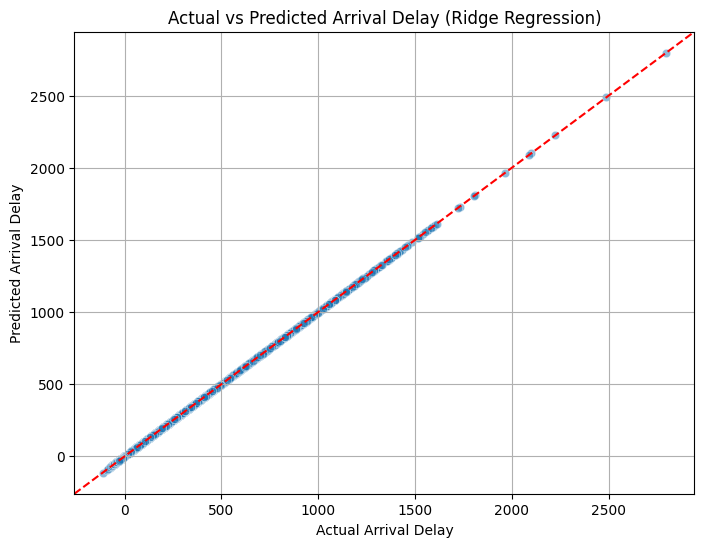

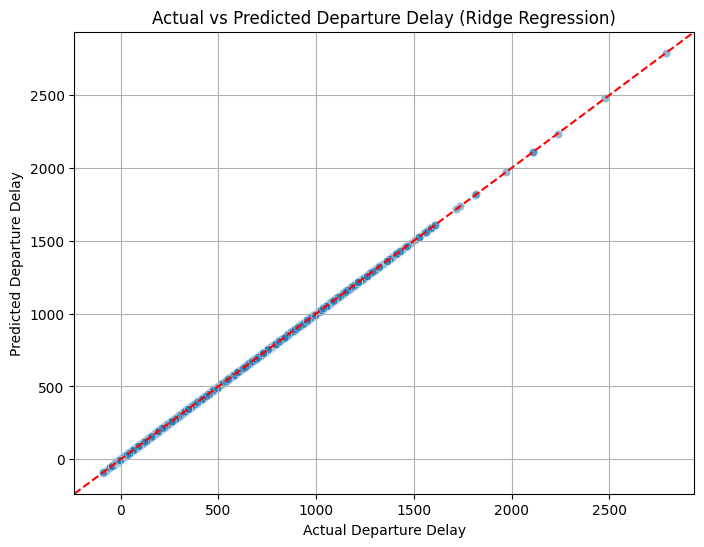

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scatter plot for Arrival Delay (Ridge Regression)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_ridge, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (Ridge Regression)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()

# 📈 Scatter plot for Departure Delay (Ridge Regression)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_ridge, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (Ridge Regression)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Line of perfect prediction
plt.grid(True)
plt.show()


In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Sample 20% of the data for testing
df1_sampled = df1.sample(frac=0.2, random_state=42)

# Select relevant features and target variables
features = ['actual_dep_time', 'actual_arr_time', 'dep_delay', 'arr_delay', 'taxi_out', 'taxi_in',
            'air_time', 'dist', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

X = df1_sampled[features].values
y_arrival = df1_sampled['arr_delay'].values
y_departure = df1_sampled['dep_delay'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split for arrival and departure separately
X_train, X_test, y_train_arrival, y_test_arrival = train_test_split(X_scaled, y_arrival, test_size=0.2, random_state=42, shuffle=False)
_, _, y_train_departure, y_test_departure = train_test_split(X_scaled, y_departure, test_size=0.2, random_state=42, shuffle=False)

# ---- Lasso for Arrival Delay ----
lasso_arrival = Lasso(alpha=0.1)
lasso_arrival.fit(X_train, y_train_arrival)
y_pred_arrival_lasso = lasso_arrival.predict(X_test)

# ---- Lasso for Departure Delay ----
lasso_departure = Lasso(alpha=0.1)
lasso_departure.fit(X_train, y_train_departure)
y_pred_departure_lasso = lasso_departure.predict(X_test)


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Metrics ---
rmse_arrival_lasso = np.sqrt(mean_squared_error(y_test_arrival, y_pred_arrival_lasso))
rmse_departure_lasso = np.sqrt(mean_squared_error(y_test_departure, y_pred_departure_lasso))

mae_arrival_lasso = mean_absolute_error(y_test_arrival, y_pred_arrival_lasso)
mse_arrival_lasso = mean_squared_error(y_test_arrival, y_pred_arrival_lasso)
r2_arrival_lasso = r2_score(y_test_arrival, y_pred_arrival_lasso)

mae_departure_lasso = mean_absolute_error(y_test_departure, y_pred_departure_lasso)
mse_departure_lasso = mean_squared_error(y_test_departure, y_pred_departure_lasso)
r2_departure_lasso = r2_score(y_test_departure, y_pred_departure_lasso)

# --- Late Ratio ---
late_threshold = 15

late_ratio_arrival_lasso = np.sum(y_pred_arrival_lasso > late_threshold) / len(y_pred_arrival_lasso)
late_ratio_departure_lasso = np.sum(y_pred_departure_lasso > late_threshold) / len(y_pred_departure_lasso)

# --- Print Results ---
print()
print("Lasso Regression")
print(f"Metric          | Arrival Delay  | Departure Delay")
print(f"-------------------------------------------------")
print(f"MAE             | {mae_arrival_lasso:.4f}       | {mae_departure_lasso:.4f}")
print(f"MSE             | {mse_arrival_lasso:.4f}       | {mse_departure_lasso:.4f}")
print(f"RMSE            | {rmse_arrival_lasso:.4f}       | {rmse_departure_lasso:.4f}")
print(f"R² Score        | {r2_arrival_lasso:.4f}       | {r2_departure_lasso:.4f}")
print(f"Late Ratio      | {late_ratio_arrival_lasso:.4f}       | {late_ratio_departure_lasso:.4f}")



Lasso Regression
Metric          | Arrival Delay  | Departure Delay
-------------------------------------------------
MAE             | 0.0509       | 0.0431
MSE             | 0.0103       | 0.0101
RMSE            | 0.1013       | 0.1005
R² Score        | 1.0000       | 1.0000
Late Ratio      | 0.2090       | 0.1696


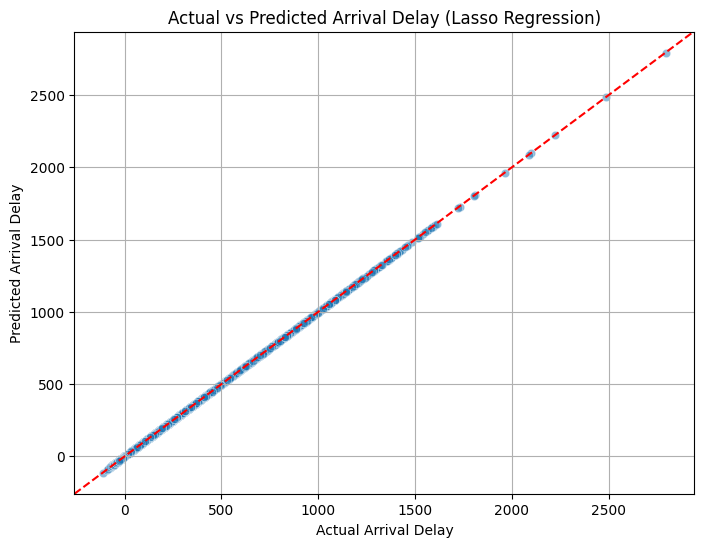

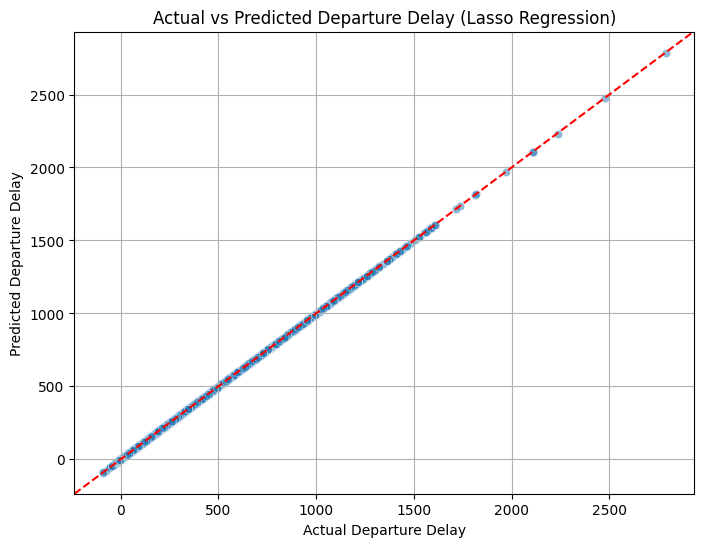

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for Arrival Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_arrival, y=y_pred_arrival_lasso, alpha=0.5)
plt.xlabel("Actual Arrival Delay")
plt.ylabel("Predicted Arrival Delay")
plt.title("Actual vs Predicted Arrival Delay (Lasso Regression)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")
plt.grid(True)
plt.show()

# Scatter plot for Departure Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_departure, y=y_pred_departure_lasso, alpha=0.5)
plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("Actual vs Predicted Departure Delay (Lasso Regression)")
plt.axline((0, 0), slope=1, color="red", linestyle="--")
plt.grid(True)
plt.show()


## Evaluation of All Models (Arrival Delays)

In [14]:
import pandas as pd

# Model Names
models = [
    "Random Forest", "Gradient Boosting", "XGBoost", "CatBoost", "TabNet",
    "KNN", "AdaBoost", "LightGBM", "Ridge Regression", "Lasso Regression"
]

# Arrival Delay Metrics
arrival_metrics = {
    "Model": models,
    "MAE": [0.0015, 0.0246, 0.5769, 0.2587, 4.6953, 3.4715, 15.4947, 0.1138, 0.0003, 0.0509],
    "MSE": [0.0421, 0.1003, 77.6823, 15.0366, 196.8029, 22.3810, 358.2151, 11.1645, 0.0000, 0.0103],
    "RMSE": [0.2051, 0.3167, 8.8138, 3.8777, 14.0286, 4.7309, 18.9266, 3.3413, 0.0004, 0.1013],
    "R2": [1.0, 1.0, 0.9803, 0.9962, 0.9500, 0.9943, 0.9090, 0.9972, 1.0, 1.0]
}

# Departure Delay Metrics
departure_metrics = {
    "Model": models,
    "MAE": [0.0015, 0.0204, 0.5894, 0.2028, 4.6160, 3.4323, 18.0458, 0.1086, 0.0003, 0.0431],
    "MSE": [0.0435, 0.0663, 78.6933, 18.1366, 126.7175, 26.3975, 379.4576, 11.4422, 0.0000, 0.0101],
    "RMSE": [0.2085, 0.2574, 8.8709, 4.2587, 11.2569, 5.1378, 19.4797, 3.3826, 0.0004, 0.1005],
    "R2": [1.0, 1.0, 0.9784, 0.9950, 0.9652, 0.9928, 0.8958, 0.9969, 1.0, 1.0]
}

# Late Ratios (threshold > 15 minutes)
late_ratios = {
    "Model": models,
    "Arrival_Late_Ratio": [1.0, 1.0, 0.9961, 1.0, 0.9850, 0.9909, 0.9926, 0.2089, 0.2094, 0.2090],
    "Departure_Late_Ratio": [1.0, 1.0, 0.9999, 0.9966, 0.9890, 0.9840, 0.9575, 0.1731, 0.1710, 0.1696]
}

# Create DataFrames
df_arrival = pd.DataFrame(arrival_metrics)
df_departure = pd.DataFrame(departure_metrics)
df_late_ratio = pd.DataFrame(late_ratios)

# Show the DataFrames
print("Arrival Delay Metrics")
print(df_arrival)

print("\nDeparture Delay Metrics")
print(df_departure)

print("\nLate Ratios (Threshold > 15 mins)")
print(df_late_ratio)


Arrival Delay Metrics
               Model      MAE       MSE     RMSE      R2
0      Random Forest   0.0015    0.0421   0.2051  1.0000
1  Gradient Boosting   0.0246    0.1003   0.3167  1.0000
2            XGBoost   0.5769   77.6823   8.8138  0.9803
3           CatBoost   0.2587   15.0366   3.8777  0.9962
4             TabNet   4.6953  196.8029  14.0286  0.9500
5                KNN   3.4715   22.3810   4.7309  0.9943
6           AdaBoost  15.4947  358.2151  18.9266  0.9090
7           LightGBM   0.1138   11.1645   3.3413  0.9972
8   Ridge Regression   0.0003    0.0000   0.0004  1.0000
9   Lasso Regression   0.0509    0.0103   0.1013  1.0000

Departure Delay Metrics
               Model      MAE       MSE     RMSE      R2
0      Random Forest   0.0015    0.0435   0.2085  1.0000
1  Gradient Boosting   0.0204    0.0663   0.2574  1.0000
2            XGBoost   0.5894   78.6933   8.8709  0.9784
3           CatBoost   0.2028   18.1366   4.2587  0.9950
4             TabNet   4.6160  126.7175  